In [1]:
import numpy as np
import pandas as pd

In [2]:
header = ['user_id','item_id','rating','timestamp']

In [3]:
df = pd.read_csv('/home/ubuntu/my_data/ml-100k/u.data', sep = '\t', names=header)

In [4]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
n_users = df.user_id.unique().shape[0]

In [7]:
n_users

943

In [10]:
n_items = df.item_id.unique().shape[0]

In [11]:
n_items

1682

In [12]:
print 'Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)

Number of users = 943 | Number of movies = 1682


In [13]:
from sklearn import cross_validation as cv

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
train_data, test_data = cv.train_test_split(df,test_size = 0.25)

In [16]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [17]:
train_data.head(6)

,user_id,item_id,rating,timestamp
59378,405,723,1,885546288
77261,484,226,4,891195390
47965,665,117,4,884290575
99387,682,1,4,888523054
9386,299,318,4,877880649
84496,914,739,2,887124376


In [18]:
test_data.head(6)

,user_id,item_id,rating,timestamp
19234,442,578,2,883390466
85392,151,301,4,879523925
14654,3,307,3,889237224
23189,196,108,4,881252110
30022,305,1073,1,886323591
11581,231,846,4,888605274


In [20]:
train_data.shape, test_data.shape

((75000, 4), (25000, 4))

### Create training and test matrix

In [21]:
R = np.zeros((n_users,n_items))

In [22]:
R

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [23]:
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3]

In [24]:
T = np.zeros((n_users, n_items))

In [25]:
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]

### Index matrix for training data

In [28]:
I = R.copy()

In [29]:
I[I > 0] = 1
I[I == 0] = 0

### Index matrix for test data

In [31]:
I2 = T.copy()

In [32]:
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [34]:
I2

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

# Stochastic Gradient Descent

In [35]:
def prediction(P, Q):
    return np.dot(P.T,Q)

In [36]:
lmbda = 0.1 # Regularisation weight
k = 20 # Dimensionality of latent feature space
m , n = R.shape # num of users and items
n_epochs = 100
gamma = 0.01 # learning rate

In [37]:
P = 3 * np.random.rand(k,m) # latent user feature matrix
Q = 3 * np.random.rand(k,n) # latent movie feature matrix

### RMSE

In [38]:
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P, Q))) * 2) / len(R[R > 0]))

In [39]:
train_errors = []
test_errors = []

In [40]:
users, items = R.nonzero()

In [42]:
for epoch in xrange(n_epochs):
    for u, i in zip(users,items):
        e = R[u, i] - prediction(P[:,u], Q[:,i]) # Calculate error for gradient
        P[:,u] += gamma * (e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
    train_rmse = rmse(I,R,Q,P) # Calculate root mean squared error from train dataset
    test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


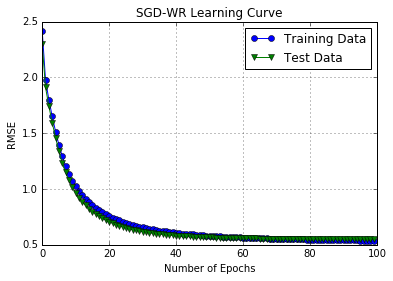

In [43]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [44]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R = pd.DataFrame(R)
R_hat=pd.DataFrame(prediction(P,Q))

In [45]:
# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[16,R.loc[16,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[16,R.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings

,Actual Rating,Predicted Rating
0,4.0,3.695432
6,4.0,3.422958
8,3.0,3.049189
12,3.0,3.287288
99,4.0,3.459918
